# Approximation of the 1-D Wave Equation With Neural Networks Using PyTorch

This notebook presents an example of approximating the solution to the 1-D wave equation using neural networks. The wave equation is a second-order linear partial differential equation that describes the propagation of a variety of waves, such as sound waves, light waves, and waves on strings.

The method used in this notebook is implemented using [PyTorch](https://pytorch.org/docs/stable/index.html), a popular open-source machine learning library. The example used in this notebook is based on the NeuralPDE library in Julia, which provides tools for solving partial differential equations with neural networks. For more details you can visit the [NeuralPDE documentation](https://docs.sciml.ai/NeuralPDE/stable/examples/wave/).  

The equation approximated in this notebook is the one-dimensional wave equation, which is a fundamental equation in physics that describes wave propagation. The equation is given by:
$$
\begin{aligned} \partial_t^2 u(x, t)=c^2 \partial_x^2 u(x, t) & \text { for all } 0<x<1 \text { and } t>0 \\ u(0, t)=u(1, t)=0 & \text { for all } t>0, \\ u(x, 0)=x(1-x) & \text { for all } 0<x<1 \\ \partial_t u(x, 0)=0 & \text { for all } 0<x<1\end{aligned}
$$

In this equation, $u(x, t)$ represents the wave function, which gives the position of the wave at location $x$ and time $t$. The term $c^2$ is the square of the wave speed, and $∂_t^2$ and $∂_x^2$ are the second derivatives with respect to time and space, respectively.

In the following code block, we import the necessary libraries for our notebook. This includes NumPy for numerical operations, PyTorch for building and training the neural network, Matplotlib for plotting, a utility module for additional plotting functions, and the time module for timing our training process.

In [1]:
# Import NumPy for numerical operations
import numpy as np

# Import PyTorch for building and training neural networks
import torch
import torch.nn as nn
import torch.optim as optim

# Import Matplotlib for plotting
import matplotlib.pyplot as plt

# Import a utility module for additional plotting functions
import utils_plots

# Import the time module to time our training process
import time

In the following code block, we define a function for the analytical solution of the 1D wave equation. We then generate training data in NumPy, create a grid of `x` and `t` values, and calculate the corresponding u values. Finally, we plot the u values as a function of `x` and `t`.

The analytical solution to the wave equation is given by the function:

$$
u(t, x) = \sum_{k=1,...,n} \frac{8}{k^3 \pi^3} \sin(k \pi x) \cos(C k \pi t)
$$

In this equation, `C` is a constant set to 1, `k` is an integer that ranges from 1 to `n`, `x` represents the spatial position, and `t` represents time. The sine and cosine functions create a wave pattern in the `x` and `t` dimensions, respectively. The fraction in front of the sine and cosine functions ensures that the wave pattern diminishes for larger values of `k`.

This function is used to generate the `u` values, which represent the wave's displacement at each point in our grid of `x` (spatial position) and `t` (time) values. This grid forms the basis for our training data, which we will use to train our neural network to approximate the wave equation.

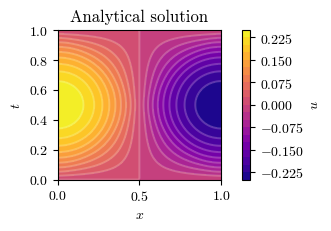

In [2]:
# Define a function for the analytical solution of the 1D wave equation
def analytic_sol_func(t, x):
    C = 1
    return sum([(8 / (k**3 * np.pi**3)) * np.sin(k * np.pi * x) * np.cos(C * k * np.pi * t) for k in range(1, 100, 2)])

# Generate training data in NumPy
x_np = np.linspace(0, 1, 100)  # x data (numpy array), shape=(100,)
t_np = np.linspace(0, 1, 100)  # t data (numpy array), shape=(100,)

# Create a grid of x and t values
x_grid, t_grid = np.meshgrid(x_np, t_np) # x and t data (numpy array), shape=(100, 100)

# Calculate u values using the analytical solution function
u_grid = analytic_sol_func(t_grid,x_grid) # u data (numpy array), shape=(100, 100)

# Create a figure for the plot
fig = plt.figure(figsize=(3.2, 2.2))

# Plot the u values as a function of t and x
plt.contourf(t_grid,x_grid,u_grid, origin='lower', extent=(0, 1, 0, 1), levels=20,cmap='plasma')
plt.colorbar(label='$u$')
plt.contour(t_grid, x_grid, u_grid, levels=20, colors='white', alpha=0.2, linestyles='solid')
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Analytical solution')

# Save the plot as a PDF file in the 'imgs' directory
fig.savefig('imgs/2_1D_Wave_Equation_Analytical_Solution.png', format='png')

# Display the plot
plt.show()

In the following code block, we convert our grid data from NumPy arrays to PyTorch tensors, which can be processed more efficiently by our neural network. We also concatenate the spatial (`x`) and temporal (`t`) tensors to form our input data.

In [3]:
# Conversion of the grid data to PyTorch tensors
x = torch.from_numpy(x_grid).float().unsqueeze(-1)
t = torch.from_numpy(t_grid).float().unsqueeze(-1)
u = torch.from_numpy(u_grid).float().unsqueeze(-1)

# Concatenation of x and y to form the input data
input_data = torch.cat((x, t), dim=-1)

In the following code block, we define our neural network model. This model is a simple feed-forward neural network with **two** hidden layers, each containing **50 neurons**. The activation function used is the hyperbolic tangent (`tanh`). We also instantiate the model, and define the optimizer (**Adam**) and the loss function (**Mean Squared Error**) to be used during training.

In [4]:
# Define a neural network class with three fully connected layers
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(2, 10)
        self.layer2 = nn.Linear(10, 10)
        self.output_layer = nn.Linear(10, 1)

    def forward(self, x):
        x = torch.tanh(self.layer1(x))
        x = torch.tanh(self.layer2(x))
        x = self.output_layer(x)
        return x
    
# Create an instance of the neural network
neural_net = NeuralNetwork()

# Define an optimizer (Adam) for training the network
optimizer = optim.Adam(neural_net.parameters(), lr=0.01)

# Define a loss function (Mean Squared Error) for training the network
loss_func = nn.MSELoss()

In the following code block, we train our neural network. We run the training process for 500 iterations, during which we feed the input data to the network, calculate the loss between the network's prediction and the actual `u` values, and update the network's parameters based on this loss. We also store the loss values for each iteration in a list for later analysis. Every 100 iterations, we print out the current iteration number and the corresponding loss value. We also enhance the summary of the training process by including additional information about the neural network and the optimizer used.

In [5]:
# Initialize a list to store the loss values
loss_values = []

# Start the timer
start_time = time.time()

# Training the neural network
for i in range(1001):
    prediction = neural_net(input_data)     # input x and predict based on x
    loss = loss_func(prediction, u)     # must be (1. nn output, 2. target)
    
    # Append the current loss value to the list
    loss_values.append(loss.item())
    
    if i % 100 == 0:  # print every 100 iterations
        print(f"Iteration {i}: Loss {loss.item()}")
    
    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()

# Stop the timer and calculate the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training time: {elapsed_time} seconds")

# Save a summary of the training process to a text file
with open("summaries/2_1D_Wave_Equation_Approximation_with_NNs.txt", "w") as file:
    file.write("Summary of Neural Network Training\n")
    file.write("=================================\n\n")
    file.write(f"Neural Network Architecture:\n{neural_net}\n\n")
    file.write(f"Optimizer Used:\n{type(optimizer).__name__}\n\n")
    file.write(f"Learning Rate:\n{optimizer.param_groups[0]['lr']}\n\n")
    file.write(f"Number of Iterations:\n{len(loss_values)}\n\n")
    file.write(f"Initial Loss:\n{loss_values[0]}\n\n")
    file.write(f"Final Loss:\n{loss_values[-1]}\n\n")
    file.write(f"Training Time:\n{elapsed_time} seconds\n\n")
    
    # Calculate the average loss
    average_loss = sum(loss_values) / len(loss_values)
    file.write(f"Average Loss:\n{average_loss}\n\n")
    
    # Find the iteration with the minimum loss
    min_loss_value = min(loss_values)
    min_loss_iteration = loss_values.index(min_loss_value)
    file.write(f"Minimum Loss:\n{min_loss_value} at iteration {min_loss_iteration}\n\n")        

Iteration 0: Loss 0.02012786827981472
Iteration 100: Loss 0.0031966085080057383
Iteration 200: Loss 0.0012080582091584802
Iteration 300: Loss 0.00020044260600116104
Iteration 400: Loss 0.00013408655649982393
Iteration 500: Loss 2.0052557374583557e-05
Iteration 600: Loss 1.53830860654125e-05
Iteration 700: Loss 1.3000762010051403e-05
Iteration 800: Loss 0.00013219538959674537
Iteration 900: Loss 1.2930438060720917e-05
Iteration 1000: Loss 1.1597035154409241e-05
Training time: 164.2108292579651 seconds


In the following code block, we plot the loss values recorded during the training process. This plot helps us visualize how the loss decreases over time, indicating that our neural network is learning to approximate the wave function more accurately with each iteration.

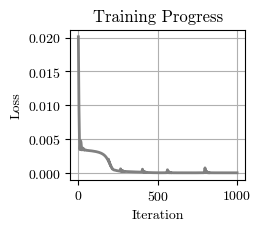

In [6]:
# Create a figure for the plot
fig = plt.figure(figsize=(2.5, 2.2))

# Plot the loss values recorded during training
plt.plot(loss_values, color='gray', linewidth=2)

# Set the labels for the x and y axes
plt.xlabel('Iteration')
plt.ylabel('Loss')

# Set the title for the plot
plt.title('Training Progress')

# Display the grid
plt.grid(True)

# Save the plot as a PDF file in the 'imgs' directory
fig.savefig('imgs/2_Training_Progress_1D_Wave_Equation_NNs.png', format='png')

# Display the plot
plt.show()

In the following code block, we save the trained model's parameters to a file. We then initialize a new instance of the neural network and load the saved parameters into this new instance. This allows us to reuse the trained model without having to retrain it.

In [7]:
# Save the trained model's parameters to a file
torch.save(neural_net.state_dict(), 'models/2_1D_Wave_Equation_NNs.pth')

# Initialize a new instance of the neural network
new_neural_net = NeuralNetwork()

# Load the saved parameters into the new instance of the neural network
new_neural_net.load_state_dict(torch.load('models/2_1D_Wave_Equation_NNs.pth'))

# Ensure the new neural network is in evaluation mode
new_neural_net.eval()

NeuralNetwork(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (output_layer): Linear(in_features=10, out_features=1, bias=True)
)

In the following code block, we use the trained neural network to generate predictions for `u` based on the input data. We then plot these predicted `u` values and the difference between the predicted and actual `u` values. This allows us to visually assess the performance of our neural network.

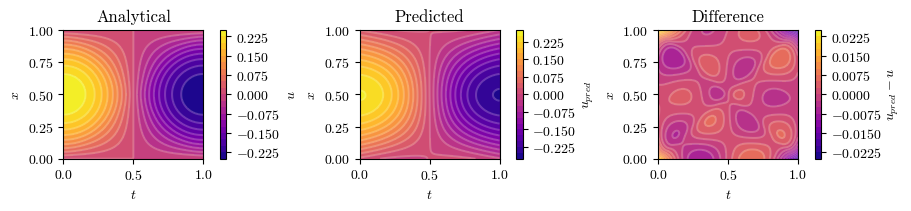

In [8]:
# Generate predictions using the neural network and reshape to match grid
u_pred = neural_net(input_data).detach().numpy().reshape(x_grid.shape)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 3, figsize=(9, 2))

# Define a function to plot a contour graph
def plot_contour(ax, x, y, z, title, label):
    im = ax.contourf(x, y, z, origin='lower', levels=20, cmap='plasma')
    ax.set_title(title)
    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    fig.colorbar(im, ax=ax, label=label)
    ax.contour(x, y, z, levels=20, colors='white', alpha=0.2, linestyles='solid')

# Plot the predicted u values
plot_contour(axs[0], t_grid, x_grid, u_grid, 'Analytical', '$u$')

# Plot the predicted u values
plot_contour(axs[1], t_grid, x_grid, u_pred, 'Predicted', '$u_{pred}$')

# Plot the difference between the predicted and analytical u values
plot_contour(axs[2], t_grid, x_grid, u_pred-u_grid, 'Difference', '$u_{pred}-u$')

# Save the plot as a PDF file in the 'imgs' directory
fig.savefig('imgs/2_Predicted_and_Difference_3_1D_Wave_Equation_Approximation_with_NNs.png', format='png')

# Display the plot
plt.show()

**Summary**

- We started by converting our grid data from NumPy arrays to PyTorch tensors, which can be processed more efficiently by our neural network.
- We then defined a simple feed-forward neural network with two hidden layers, each containing 50 neurons. The activation function used was the hyperbolic tangent (`tanh`).
- We trained the neural network for 1000 iterations, during which we fed the input data to the network, calculated the loss between the network's prediction and the actual `u` values, and updated the network's parameters based on this loss.
- We plotted the loss values recorded during the training process to visualize how the loss decreased over time, indicating that our neural network was learning to approximate the wave function more accurately with each iteration.
- We saved the trained model parameters to a file and showed how to load these parameters back into a new instance of the model.
- Finally, we used the trained neural network to generate predictions for `u` based on the input data, and plotted these predicted `u` values and the difference between the predicted and actual `u` values. This allowed us to visually assess the performance of our neural network.